In [995]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [996]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [997]:
PATH_HR = "../Dati/19-04/2 batch/Run_Cs_chall_ChargeHistos_4_19_2024_high_range.dat"
PATH_LR = "../Dati/19-04/2 batch/Run_Cs_chall_ChargeHistos_4_19_2024_low_range.dat"
channel = 15

if(channel == 12 or channel == 13 or channel == 1 or channel == 9):
    raise Exception("Cambia canale")

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, -1, 8, 9, -1, -1, 10, 11]

if channel in [0, 2, 6, 10, 11, 14]:
    edge_N, bin_N = load_histo(PATH_LR)
else:
    edge_N, bin_N = load_histo(PATH_HR)


edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


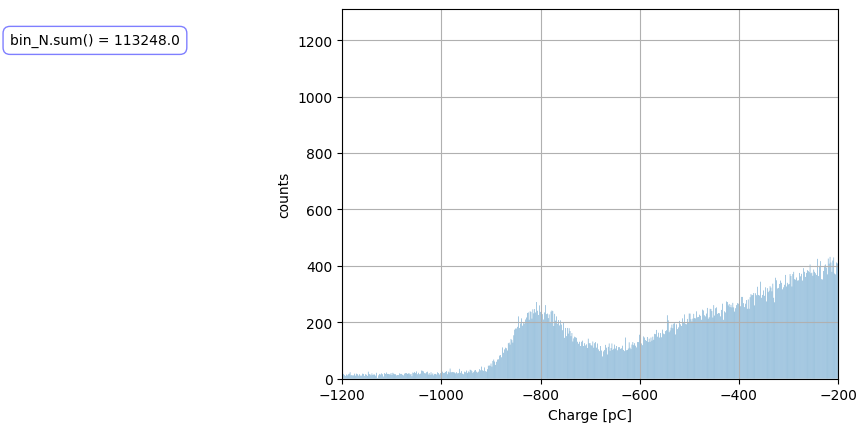

In [998]:
lim_list = [[-650, -175],  #ch0
            [-1, -1],      #ch1
            [-600, -175],  #ch2
            [-1500, -245],  #ch3
            [-2000, -400],  #ch4
            [-2000, -275],  #ch5
            [-600, -155],  #ch6
            [-2000, -100],  #ch7
            [-2000, -170],  #ch8
            [-500, -160],  #ch9
            [-600, -200],  #ch10
            [-950, -200],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-950, -200],  #ch14
            [-1200, -200]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, snap = False)#, width = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")
plt.show()

In [999]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]



In [1000]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [1001]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

if (channel <14):
    noise_params = noise_params[channel]
elif(channel==14):
    noise_params = noise_params[12]
elif(channel==15):
    noise_params = noise_params[13]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.316e+04     -inf      inf      190     True     None     None
e1_decay        -83.88     -inf      inf   0.6513     True     None     None
ratio            23.95     -inf      inf   0.4402    False e1_amplitude / s1_amplitude     None
s1_amplitude     549.3        0      inf    9.749     True     None     None
s1_center       -400.3     -inf      inf   0.9277     True     None     None
s1_sigma         28.79        0      inf   0.6732     True     None     None


In [1004]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
#params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 11348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 40, min=0, max = 140)
    params["s2_center"].set(value = -221, min=-250,max=-150 )
    params["s2_sigma"].set(value = 8)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-101)

    params["s1_amplitude"].set(value= 60, min = 20, max = 60)
    params["s1_center"].set(value=-350, min = -550)
    params["s1_sigma"].set( value= 20)


if channel ==2:

    params["g1_amplitude"].set(value = 11348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 100, min=0, max = 140)
    params["s2_center"].set(value = -221, min=-250,max=-150 )
    params["s2_sigma"].set(value = 8, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-101)

    params["s1_amplitude"].set(value= 60, min = 20, max = 60)
    params["s1_center"].set(value=-350, min = -550)
    params["s1_sigma"].set( value= 40, min = 0)

if channel ==3:
    params["g1_amplitude"].set(value = 25348, min=0 )   
    params["g1_center"].set(value = -955, min = -1050 , max = -900)        
    params["g1_sigma"].set(value = 55)

    params["s2_amplitude"].set(value = 50, min=0, max = 140)
    params["s2_center"].set(value = -510, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 50, min = 20, max = 60)
    params["s1_center"].set(value=-1100)
    params["s1_sigma"].set( value= 40, min = 0)


if channel == 4:
    
    params["g1_amplitude"].set(value = 25348, min=0 )   
    params["g1_center"].set(value = -1550, min = -1650 , max = -140)        
    params["g1_sigma"].set(value = 55)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)


    
   
if channel == 5:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1530, min = -1650 , max = -140)        
    params["g1_sigma"].set(value = 66)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)

if channel ==6:
    params["g1_amplitude"].set(value = 11348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 40, min=0, max = 140)
    params["s2_center"].set(value = -221, min=-250,max=-150 )
    params["s2_sigma"].set(value = 8, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-101)

    params["s1_amplitude"].set(value= 60, min = 20, max = 60)
    params["s1_center"].set(value=-350, min = -550)
    params["s1_sigma"].set( value= 40, min = 0)

if channel ==7:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1700, min = -1850 , max = -140)        
    params["g1_sigma"].set(value = 66)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)

 
if channel == 8:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1100, min = -1200 , max = -1000)        
    params["g1_sigma"].set(value = 50)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)



if channel == 10:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -389, min = -450 , max = -350)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -270, min=-300,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 11:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -559, min = -600 , max = -500)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -350, min=-400,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 14:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -559, min = -600 , max = -500)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -350, min=-400,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 15:
    params["g1_amplitude"].set(value = 25348, min=0 )   
    params["g1_center"].set(value = -800, min = -900 , max = -700)        
    params["g1_sigma"].set(value = 50)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -500, min=-700,max=-400 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 600, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 40, min = 20)
    params["s1_center"].set(value=-800)
    params["s1_sigma"].set( value= 40, min = 0)

       






params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude       600        0      inf     None     True     None     None
e1_decay          -250     -inf      inf     None     True     None     None
g1_amplitude  2.535e+04        0      inf     None     True     None     None
g1_center         -800     -900     -700     None     True     None     None
g1_fwhm          117.7     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height        202.2     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            50        0      inf     None     True     None     None
s1_amplitude        40       20      inf     None     True     None     None
s1_center         -800     -inf      inf     None     True     None     None
s1_sigma            40        0      inf     None     True     None     None
s2_amplitude       140        0      140     None     True     None     None
s2_center         -500     -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


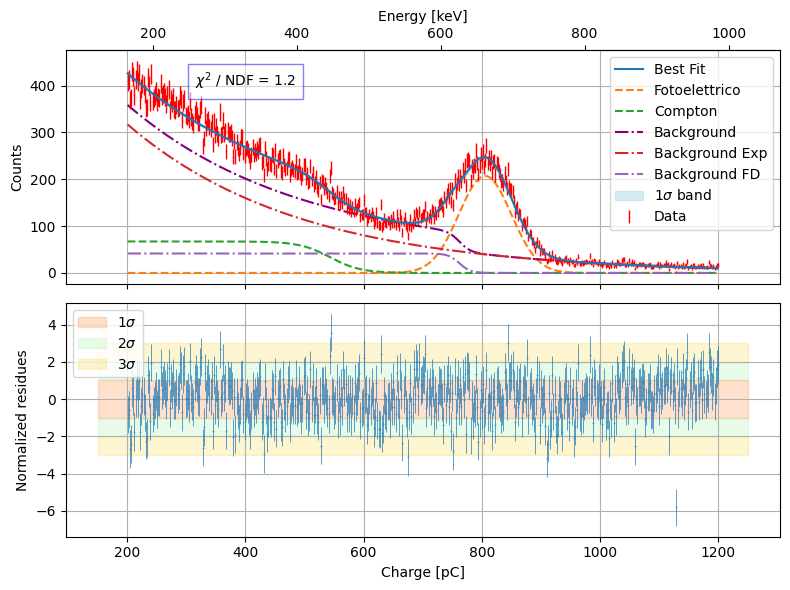

In [1005]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, method = "leastsq")

def pCtoKev(x):
    return -x / result.params["g1_center"].value * 661.7

def KevtopC(x):
    return -x * result.params["g1_center"].value / 661.7



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)


#ax1.bar(centers_N, bin_N, alpha = 0.5, width = 0.7)
#ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(-centers_N[::-1], result.best_fit[::-1], label='Best Fit', zorder = 10)
ax1.plot(-centers_N[::-1], comps['g1_'][::-1], label='Fotoelettrico', ls = "--")
ax1.plot(-centers_N[::-1], comps['s2_'][::-1], label='Compton', ls = "--")

ax1.plot(-centers_N[::-1], comps['e1_'][::-1] + comps['s1_'][::-1], label='Background', ls = "-.",
         color = "purple")
         #color = "#17BEBB")
ax1.plot(-centers_N[::-1], comps['e1_'][::-1], label='Background Exp', ls = "-.")
ax1.plot(-centers_N[::-1], comps['s1_'][::-1], label='Background FD', ls = "-.")

ax1.errorbar(-centers_N[::-1], bin_N[::-1], err_N[::-1], color = "red", fmt='|', linewidth = 1, 
             markersize = 0.5, label = "Data")


dely = result.eval_uncertainty(sigma=1)
ax1.fill_between(-centers_N[::-1],
                        (result.best_fit-result.dely)[::-1],
                        (result.best_fit+result.dely)[::-1],
                        color="lightblue", alpha = 0.5, label = r'$1\sigma$ band')

ax1.text(-np.max(lim_N) * 2, bin_N.max(), r'$\chi^2$ / NDF = ' + str(round(result.redchi, 1)), 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))

ax1.grid()
ax1.legend(loc = 1)


residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(-centers_N[::-1], norm_resCs[::-1], 1, ls = "", marker = ".", linewidth = 0.5, markersize = 0.5)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "#FF6700", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "#F7CB15", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "#F7CB15", alpha = 0.2)

ax2.legend()

secax = ax1.secondary_xaxis('top', functions=(pCtoKev, KevtopC))
secax.set_xlabel('Energy [keV]')
'''
ax3 = ax2.twinx()
ax3.set_xticks(pCtoKev(np.array(ax1.get_xticks())))
ax3.set_xlabel("Energy [keV]")
ax3.set_xticklabels(np.round(pCtoKev( np.array(ax1.get_xticks())) ))
ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax3.spines['bottom'].set_position(('outward', 36))

ax3.set_xlim(np.array(ax1.get_xlim()) * -result.params["g1_center"].value / 661.7)


ax3.plot()
'''
fig.tight_layout()

plt.show()

In [1006]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 260
    # data points      = 521
    # variables        = 11
    chi-square         = 635.191528
    reduced chi-square = 1.24547358
    Akaike info crit   = 125.249973
    Bayesian info crit = 172.063223
    R-squared          = 0.99991667
[[Variables]]
    e1_amplitude:  632.511689 +/- 21.7350999 (3.44%) (init = 600)
    e1_decay:     -290.912118 +/- 3.36188292 (1.16%) (init = -250)
    s1_amplitude:  41.5833782 +/- 2.42322166 (5.83%) (init = 40)
    s1_center:    -762.014252 +/- 7.69289197 (1.01%) (init = -800)
    s1_sigma:      9.38401970 +/- 4.02949114 (42.94%) (init = 40)
    g1_amplitude:  23003.6970 +/- 553.096854 (2.40%) (init = 25348)
    g1_center:    -805.402500 +/- 1.27243600 (0.16%) (init = -800)
    g1_sigma:      44.30552

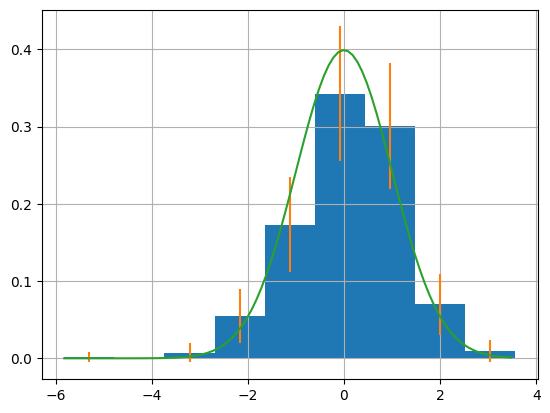

In [1007]:
res_nrm = norm_resCs.sum()
res_bin, res_edg, _ = plt.hist(norm_resCs, density = True, bins = 9)
res_cntrs = np.convolve(res_edg, [0.5, 0.5], 'valid')
res_err = np.sqrt(res_bin * res_nrm) / res_nrm
plt.errorbar(res_cntrs, res_bin, res_err, ls = "")
res_x = np.arange(res_edg[0], res_edg[-1], 0.1)
plt.plot(res_x, 1 / np.sqrt(2 * np.pi) * np.exp(-res_x*res_x / 2))
plt.grid()

res_res = ((res_bin - 1 / np.sqrt(2 * np.pi) * np.exp(-res_cntrs*res_cntrs / 2)) / res_err)**2

In [1008]:
res_res.sum()

inf

## Sistematiche

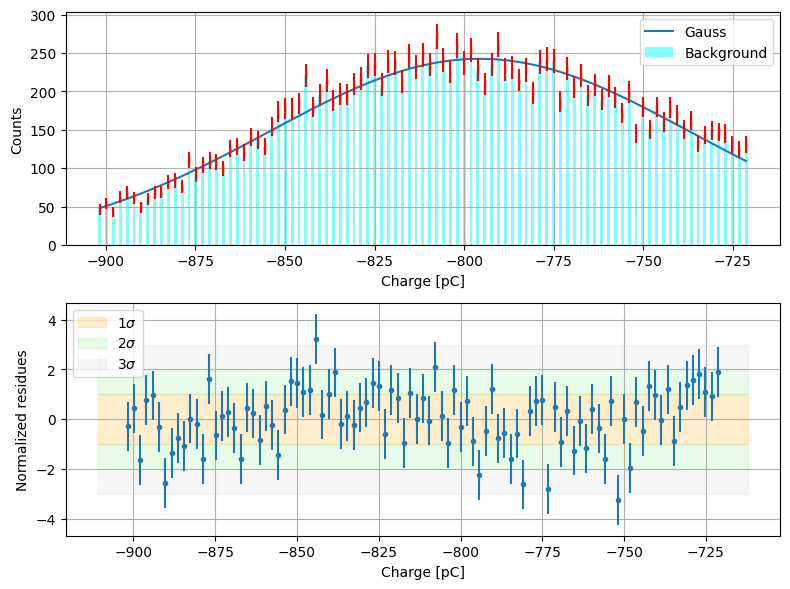

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 95
    # variables        = 3
    chi-square         = 134.236943
    reduced chi-square = 1.45909720
    Akaike info crit   = 38.8443098
    Bayesian info crit = 46.5059404
    R-squared          = 0.99961145
[[Variables]]
    g3_amplitude:  35825.5577 +/- 433.148181 (1.21%) (init = 39571.2)
    g3_center:    -795.684943 +/- 0.83085202 (0.10%) (init = -796.7228)
    g3_sigma:      58.9237626 +/- 0.92411752 (1.57%) (init = 57.6)
    g3_fwhm:       138.754853 +/- 2.17613043 (1.57%) == '2.3548200*g3_sigma'
    g3_height:     242.556313 +/- 3.09088025 (1.27%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.6059
    C(g3_center, g3_sigma)     = +0.4425
    C(g3_amplitude, g3_center) = +0.3760


In [1017]:
sist_lim_list = [[230, 285],  #ch0
                [-1, -1],  #ch1
                [250, 315],  #ch2
                [230, 325],  #ch3
                [230, 330],  #ch4
                [150, 320],  #ch5
                [315, 380],  #ch6
                [110, 200],  #ch7
                [380, 500],  #ch8
                [340, 470],  #ch9
                [190, 270],  #ch10
                [380, 480],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [380, 495],  #ch14
                [155, 250]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [1018]:
print(f'La sistematica è {result.params["g1_center"].value - result2.params["g3_center"].value}')

La sistematica è -9.717557051923109
